In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))


# Any results you write to the current directory are saved as output.

['test.csv.zip', 'train.csv', 'train.csv.zip', 'test.csv', '.DS_Store', 'embeddings']


In [17]:
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Dropout, Concatenate, Lambda, Flatten
from keras.layers import GlobalMaxPool1D
from keras.models import Model


import tqdm


# Combinations
This kernel would contain a combination of previousle tested models. For example, it may be useful to combine pretrained embeddings with ones that were trained on this particular datase.

# Embeddings

In [18]:
MAX_SEQUENCE_LENGTH = 60
MAX_WORDS = 45000
EMBEDDINGS_TRAINED_DIMENSIONS = 100
EMBEDDINGS_LOADED_DIMENSIONS = 300

## Pretrained
Load (one of) the embeddings

In [19]:
def load_embeddings(file):
    embeddings = {}
    with open(file) as f:
        def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
        embeddings = dict(get_coefs(*line.split(" ")) for line in f)
        
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

# Data
Load the data.

In [20]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

In [21]:
BATCH_SIZE = 512
Q_FRACTION = 1
questions = df_train.sample(frac=Q_FRACTION)
question_texts = questions["question_text"].values
question_targets = questions["target"].values
test_texts = df_test["question_text"].fillna("_na_").values

print(f"Working on {len(questions)} questions")

Working on 1306122 questions


In [22]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(list(df_train["question_text"].values))

In [23]:
# custom_embeddings = train_w2v(question_texts, epochs=5)
pretrained_embeddings = load_embeddings("input/embeddings/glove.840B.300d/glove.840B.300d.txt")


Found 2196016 word vectors.


In [24]:
from collections import defaultdict

def create_embedding_weights(tokenizer, embeddings, dimensions):
    not_embedded = defaultdict(int)
    
    word_index = tokenizer.word_index
    words_count = min(len(word_index), MAX_WORDS)
    embeddings_matrix = np.zeros((words_count, dimensions))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        if word not in embeddings:
            not_embedded[word] = not_embedded[word] + 1
            continue
        embedding_vector = embeddings[word]
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
            
    print(sorted(not_embedded, key=not_embedded.get)[:10])
    return embeddings_matrix

In [25]:
# custom_emb_weights = create_embedding_weights(tokenizer, custom_embeddings, EMBEDDINGS_TRAINED_DIMENSIONS)
pretrained_emb_weights = create_embedding_weights(tokenizer, pretrained_embeddings, EMBEDDINGS_LOADED_DIMENSIONS)

["what's", "i'm", "isn't", "i've", 'i’m', "you've", 'don’t', "aren't", 'what’s', "won't"]


# Model
Construct the model to use, e.g. a simple NN

In [26]:
from keras.layers import Conv2D, Reshape, MaxPool2D

filter_sizes = [1,2,3,5]
num_filters = 42

def create_model():
    tokenized_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="tokenized_input")
    
    pretrained = Embedding(MAX_WORDS,
                           EMBEDDINGS_LOADED_DIMENSIONS,
                           weights=[pretrained_emb_weights],
                           trainable=False)(tokenized_input)

    pretrained = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDINGS_LOADED_DIMENSIONS, 1))(pretrained)
    pretrained = Dropout(0.2)(pretrained)
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDINGS_LOADED_DIMENSIONS),
                    kernel_initializer='he_normal', activation='tanh')(pretrained)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDINGS_LOADED_DIMENSIONS),
                    kernel_initializer='he_normal', activation='tanh')(pretrained)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDINGS_LOADED_DIMENSIONS),
                    kernel_initializer='he_normal', activation='tanh')(pretrained)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], EMBEDDINGS_LOADED_DIMENSIONS),
                    kernel_initializer='he_normal', activation='tanh')(pretrained)
    maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[3] + 1, 1))(conv_3)

    d0 = Dense(4)(maxpool_0)
    d1 = Dense(4)(maxpool_1)
    d2 = Dense(4)(maxpool_2)
    d3 = Dense(4)(maxpool_3)
    
    x = Concatenate(axis=1)([d0, d1, d2, d3])
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[tokenized_input], outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

model = create_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tokenized_input (InputLayer)    (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 300)      13500000    tokenized_input[0][0]            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 60, 300, 1)   0           embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 60, 300, 1)   0           reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_5 (

# Model evaluation




In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

THRESHOLD = 0.35

class F1EpochCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.precisions = []
        self.accuracies = []
        
    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(self.validation_data[0])
        predictions = (predictions > THRESHOLD).astype(int)
        predictions = np.asarray(predictions)
        targets = self.validation_data[1]
        f1 = metrics.f1_score(targets, predictions)
        precision = metrics.precision_score(targets, predictions)
        accuracy = metrics.accuracy_score(targets, predictions)

        print("Epoch {0}\n\tF1 score: {1:.4f}, Precision: {2:.4f}, Accuracy: {3:.4f}"
              .format(epoch, f1, precision, accuracy))
        self.f1s.append(f1)
        self.precisions.append(precision)
        self.accuracies.append(accuracy)
        return
    
def display_model_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def display_model_f1(f1_callback):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(f1_callback.f1s)
    plt.title('F1')
    plt.ylabel('F1')
    plt.xlabel('Epoch')

    plt.subplot(1, 3, 2)
    plt.plot(f1_callback.precisions)
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')

    plt.subplot(1, 3, 3)
    plt.plot(f1_callback.accuracies)
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend(['F1 score', 'Precision'], loc='upper right')
    plt.show()

# Training
Train the model. Also, experiment with different versions

## Prepare the data first
E.g. the tokenized words as well as the nlp features

In [36]:
train_X = pad_sequences(tokenizer.texts_to_sequences(question_texts),
                        maxlen=MAX_SEQUENCE_LENGTH)

test_word_tokens = pad_sequences(tokenizer.texts_to_sequences(test_texts),
                       maxlen=MAX_SEQUENCE_LENGTH)

## Alternative models

In [31]:
def make_model(filter_size):
    tokenized_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="tokenized_input")
    
    pretrained = Embedding(MAX_WORDS,
                           EMBEDDINGS_LOADED_DIMENSIONS,
                           weights=[pretrained_emb_weights],
                           trainable=False)(tokenized_input)

    pretrained = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDINGS_LOADED_DIMENSIONS, 1))(pretrained)
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDINGS_LOADED_DIMENSIONS),
                    kernel_initializer='he_normal', activation='tanh')(pretrained)
    maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1))(conv_0)

    d0 = Dense(4)(maxpool_0)

    x = Flatten()(d0)
    x = Dropout(0.1)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[tokenized_input], outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

CNN MODEL WITH FILTER OF SIZE 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenized_input (InputLayer) (None, 60)                0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 60, 300)           13500000  
_________________________________________________________________
reshape_14 (Reshape)         (None, 60, 300, 1)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 1, 42)         12642     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1, 1, 42)          0         
_________________________________________________________________
dense_33 (Dense)             (None, 1, 1, 4)           172       
_________________________________________________________________
flatten_14 (Flatten)         (None, 4)      

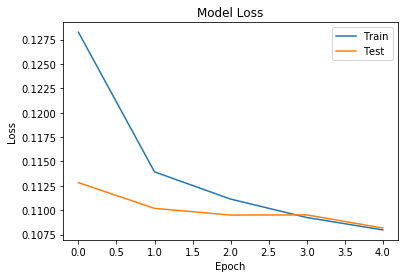

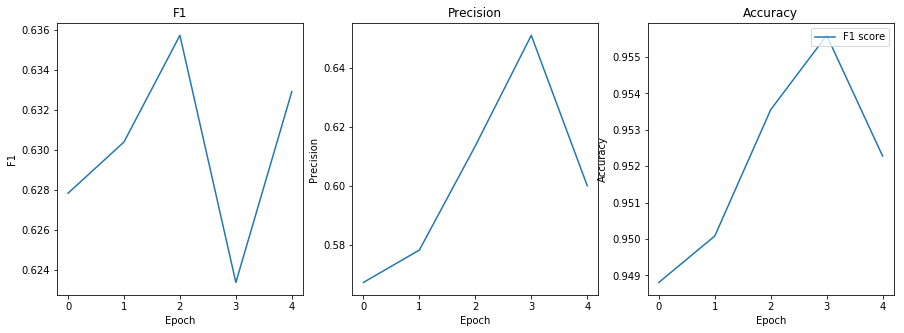

56370/56370 [==============================] - 1s 19us/step
CNN MODEL WITH FILTER OF SIZE 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenized_input (InputLayer) (None, 60)                0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 60, 300)           13500000  
_________________________________________________________________
reshape_15 (Reshape)         (None, 60, 300, 1)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 60, 1, 42)         12642     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 1, 1, 42)          0         
_________________________________________________________________
dense_35 (Dense)             (None, 1, 1, 4)           172       
__________________________________________________

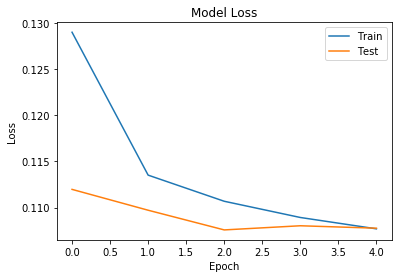

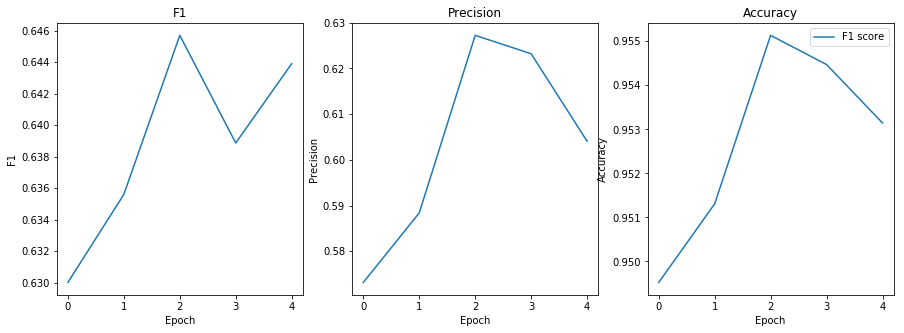

56370/56370 [==============================] - 1s 19us/step
CNN MODEL WITH FILTER OF SIZE 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenized_input (InputLayer) (None, 60)                0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 60, 300)           13500000  
_________________________________________________________________
reshape_16 (Reshape)         (None, 60, 300, 1)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 60, 1, 42)         12642     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 1, 42)          0         
_________________________________________________________________
dense_37 (Dense)             (None, 1, 1, 4)           172       
__________________________________________________

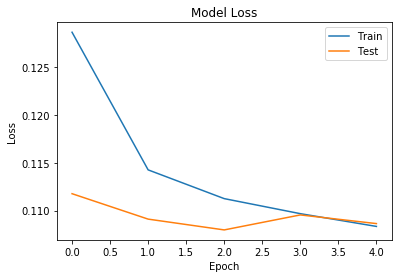

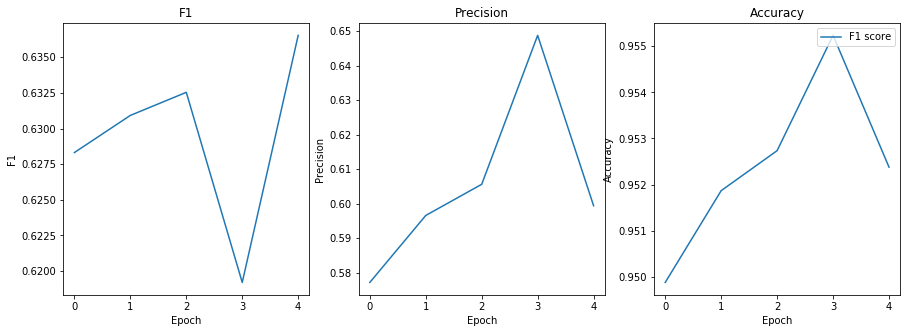

56370/56370 [==============================] - 1s 19us/step
CNN MODEL WITH FILTER OF SIZE 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tokenized_input (InputLayer) (None, 60)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 60, 300)           13500000  
_________________________________________________________________
reshape_17 (Reshape)         (None, 60, 300, 1)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 1, 42)         12642     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 1, 1, 42)          0         
_________________________________________________________________
dense_39 (Dense)             (None, 1, 1, 4)           172       
__________________________________________________

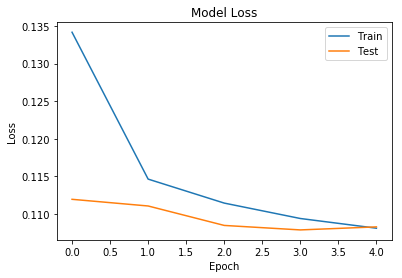

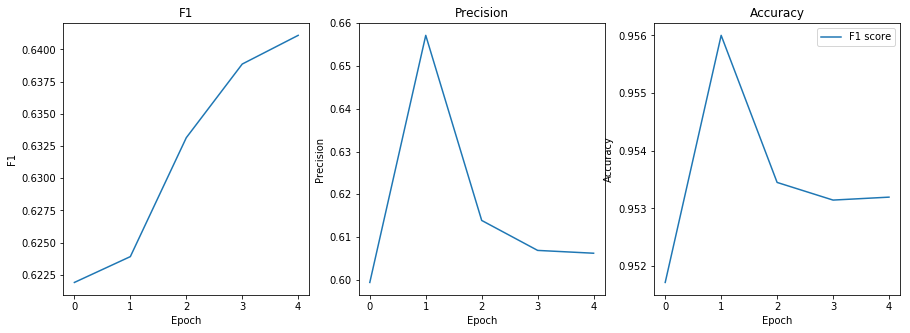

56370/56370 [==============================] - 1s 19us/step


In [44]:
filter_sizes = [1, 2, 3, 5]

predictions = []

for f in filter_sizes:
    print("CNN MODEL WITH FILTER OF SIZE {0}".format(f))
    f1_callback = F1EpochCallback()
    model = make_model(f)
    history = model.fit(
        x=[train_X],
        y=question_targets,
        batch_size=512, epochs=5, callbacks=[f1_callback], validation_split=0.015,
        verbose=2)
    display_model_history(history)
    display_model_f1(f1_callback)
    
    pred_test = model.predict([test_word_tokens], batch_size=1024, verbose=1)
#     pred_test = (pred_test > THRESHOLD).astype(int)
    predictions.append(pred_test)
    


In [48]:
len(predictions)
np.shape(predictions)
avg = np.average(predictions, axis=0)
np.shape(avg)
avg[:5]

(56370, 1)

# Results

In [49]:
# test_word_tokens = pad_sequences(tokenizer.texts_to_sequences(test_texts),
#                        maxlen=MAX_SEQUENCE_LENGTH)

# pred_test = model.predict([test_word_tokens], batch_size=1024, verbose=1)

pred_test = (avg > THRESHOLD).astype(int) 

df_out = pd.DataFrame({"qid":df_test["qid"].values})
df_out['prediction'] = pred_test
df_out.to_csv("submission.csv", index=False)